In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path

directory = '/Users/kelstonchen/Documents/QueensMA/MA_Essay/'

# PLOTTING
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='deep', style='ticks') # set theme
plt.rc("axes.spines", top=False, right=False) # remove top and right spines for all charts

# STATSMODELS
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# IMPORT DATA

In [2]:
data_path = os.path.join(directory, "data", "time_series_data")

# Load sentiment data
text_data = pd.read_csv(os.path.join("data", "mpr_data_merged", "data_deep_model_ready_V3.csv"))
pred_sentiment_class_xgb = pd.read_csv(os.path.join(data_path, "xgboost_predicted_sentiment.csv"))
pred_sentiment_class_glove = pd.read_csv(os.path.join(data_path, "glove_model_predicted_sentiment.csv"))

# Load time series data
corra_raw = pd.read_csv(os.path.join(data_path, "corra_data.csv"))
prime_raw = pd.read_csv(os.path.join(data_path, "prime_rate.csv"))
cpi_raw = pd.read_csv(os.path.join(data_path, "cpi_data.csv")).drop('gas', axis=1)
unemp_raw = pd.read_csv(os.path.join(data_path, "unemp_data.csv"))
gdp_raw = pd.read_csv(os.path.join(data_path, "gdp_data.csv"))
# missing 2023 Q2 - estimate with TD forecast
gdp_raw = pd.concat([
    gdp_raw, 
    pd.DataFrame({'date': '2023-04-01', 'gdp': 550730.3 * (1 + 0.011)}, index=[len(gdp_raw)]) # GDP growth estimate from TD 1.1%
])
fx_raw = pd.read_csv(os.path.join(data_path, "fx_data.csv"))

## Index GDP (base = 2005)

In [3]:
# Convert GDP from $$ unit to an index using 2005 as the base year
base_2005 = float(gdp_raw.loc[gdp_raw['date'] == '2005-01-01']['gdp'])
gdp_raw['gdp'] = (gdp_raw['gdp'] / base_2005) * 100

# Plot Sentiment

In [4]:
def calculate_sentiment(df):
    """
    Create a sentiment score:
    
    (# pos sents + # neg sents) / (# pos sents + # neutral sents + # neg sents)
    
    The sentiment score is calculated per MPR.
    """    
    num_neutral_sents = df[df['class'] == 1].groupby('mpr')['class'].count() # neutral
    num_neg_sents = df[df['class'] == 0].groupby('mpr')['class'].count() # negative
    num_pos_sents = df[df['class'] == 2].groupby('mpr')['class'].count() # positive

    return (num_pos_sents - num_neg_sents) / (num_pos_sents + num_neutral_sents + num_neg_sents)

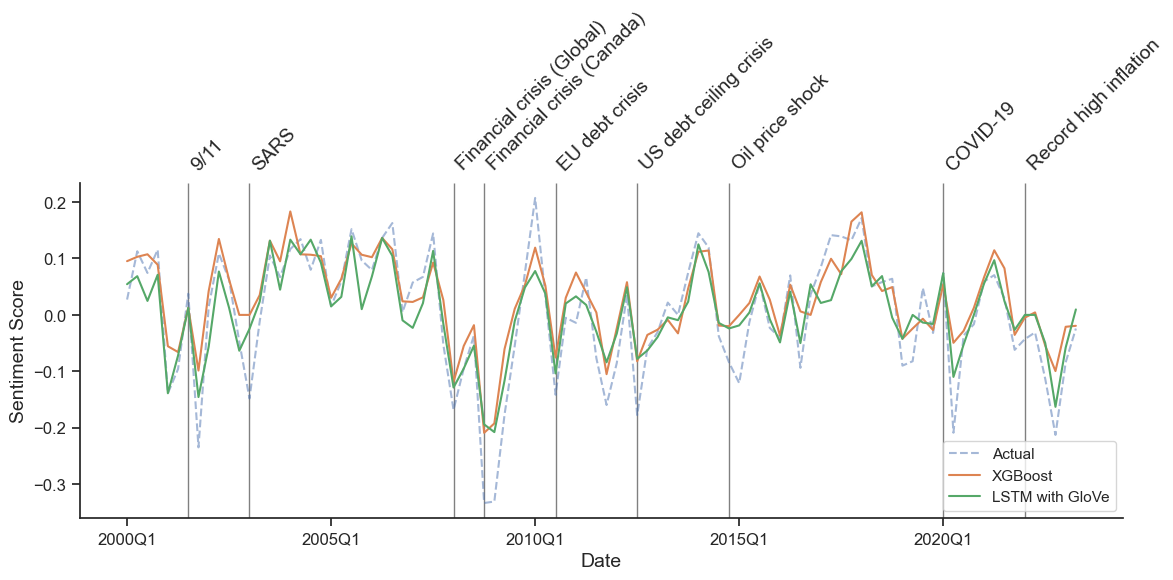

In [5]:
# Generate prediction series'
actual_sentiment_by_mpr = calculate_sentiment(text_data)
actual_sentiment_by_mpr.name='sentiment'
pred_sentiment_weighted_xgb = calculate_sentiment(pred_sentiment_class_xgb)
pred_sentiment_weighted_xgb.name='sentiment'
pred_sentiment_weighted_glove = calculate_sentiment(pred_sentiment_class_glove)
pred_sentiment_weighted_glove.name='sentiment'

# Plot prediction series'
fig, ax = plt.subplots(figsize=(12, 6))
actual_sentiment_by_mpr.plot(ax=ax, label='Actual', alpha=0.5, linestyle='--')
pred_sentiment_weighted_xgb.plot(ax=ax, label='XGBoost')
pred_sentiment_weighted_glove.plot(ax=ax, label='LSTM with GloVe')

# Plot landmarks #
ax.axvspan(6, 6, color='grey', alpha=1) # 9/11
ax.axvspan(12, 12, color='grey', alpha=1) # SARS
ax.axvspan(32, 32, color='grey', alpha=1) # Fin crisis (Global)
ax.axvspan(35, 35, color='grey', alpha=1) # Fin crisis (CAN)
ax.axvspan(42, 42, color='grey', alpha=1) # EU debt crisis
ax.axvspan(50, 50, color='grey', alpha=1) # US debt ceiling crisis
ax.axvspan(59, 59, color='grey', alpha=1) # Oil price shock
ax.axvspan(80, 80, color='grey', alpha=1) # COVID
ax.axvspan(88, 88, color='grey', alpha=1) # Inflation spike


# Text labels for each landmark
font_size = 14
ax.text(6, 0.25, '9/11', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(12, 0.25, 'SARS', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(32, 0.25, 'Financial crisis (Global)', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(35, 0.25, 'Financial crisis (Canada)', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(42, 0.25, 'EU debt crisis', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(50, 0.25, 'US debt ceiling crisis', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(59, 0.25, 'Oil price shock', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(80, 0.25, 'COVID-19', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(88, 0.25, 'Record high inflation', rotation=45, verticalalignment='bottom', fontsize=font_size)


# Axis
ax.set_xlabel("Date", fontsize=font_size)
ax.set_ylabel("Sentiment Score", fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size-2)
plt.legend()


plt.tight_layout()
plt.savefig(os.path.join(directory, "Data", "OUTPUT", "figures", "prediction_series.png"), dpi=300)

In [6]:
# # Code to find index corresponding to date
# date_to_index_dict = {
#     key: value for key, value in zip(list(actual_sentiment_by_mpr.index), list(range(0, len(actual_sentiment_by_mpr))))
# }

# date_to_index_dict['2022Q1']

# Time series data

In [7]:
def set_date_to_datetime(date_column):
    # Set to DateTime
    if type(date_column) is object:
        return pd.to_datetime(date_column, format="%Y-%m")
    return date_column

def set_datetime_to_period_index(date_series):
    # Set to PeriodIndex - Quarterly
    return pd.PeriodIndex(date_series, freq='Q')

def get_moving_average(df):
    df = df.reset_index()
    return df.groupby('date').mean()

def snip_date(df):
    df = df.reset_index()
    return df.set_index('date').loc['2000':]

### NEW - TEST ###
def log(df):
    return np.log(df)
######

def preprocess_data(df, date_column, return_log=False):
    """
    Run all of the preprocessing steps 
    for time series data.
    
    1. turn date to time object at quarterly freq
    2. get moving average
    3. get the change
    """
    # Set time to quarterly frequency
    df[date_column] = set_datetime_to_period_index(
        df[date_column].apply(set_date_to_datetime)
    )
    
    ### TEST - LOG ###
    if return_log:
        df.iloc[:, 1:] = log(df.iloc[:, 1:])
    ########
    
    # Get quarterly moving average
    df = get_moving_average(df)
    # Get the change/difference - need DATE as INDEX...
    df = df.diff()
    # Snip to 2000Q1 to 2023Q2
    df = snip_date(df)
    
    # Drop first observation (NaN value) and 
    # reset the index so date is a column
    return df.dropna().drop('index', axis=1)

def rename_index(series):
    """
    For the modelling part its easier to have the prediction data
    and the macro variable data to have the same index name 
    for date
    """
    df = pd.DataFrame(series)
    df = df.reset_index().rename(columns={'mpr':'date'})
    # return a DataFrame (where `mpr` is now `date`)
    if 'index' in df.columns:
        return df.drop('index', axis=1)
    return df

In [8]:
# PREPROCESS DATA #
"""
All time series data become "changes in X"
after preprocessing.
"""
prime = preprocess_data(prime_raw, 'date')
corra = preprocess_data(corra_raw, 'date')
cpi = preprocess_data(cpi_raw, 'date', return_log=False)
unemp = preprocess_data(unemp_raw, 'date', return_log=False)
gdp = preprocess_data(gdp_raw, 'date', return_log=False)
fx = preprocess_data(fx_raw, 'date', return_log=False)

# rename index from `mpr` to `date`
pred_sentiment_weighted_glove = rename_index(pred_sentiment_weighted_glove)
actual_sentiment_by_mpr = rename_index(actual_sentiment_by_mpr)
pred_sentiment_weighted_xgb = rename_index(pred_sentiment_weighted_xgb)

# Turn date in prediction data to PeriodIndex type
pred_sentiment_weighted_glove['date'] = set_datetime_to_period_index(pred_sentiment_weighted_glove['date'].apply(set_date_to_datetime))
pred_sentiment_weighted_glove.set_index('date', inplace=True) # set index to date

In [9]:
# Correlation between CORRA and Sentiment
np.corrcoef(
    corra['corra'].values, 
    pred_sentiment_weighted_glove['sentiment'].values
)[1][0]

0.33846676219607563

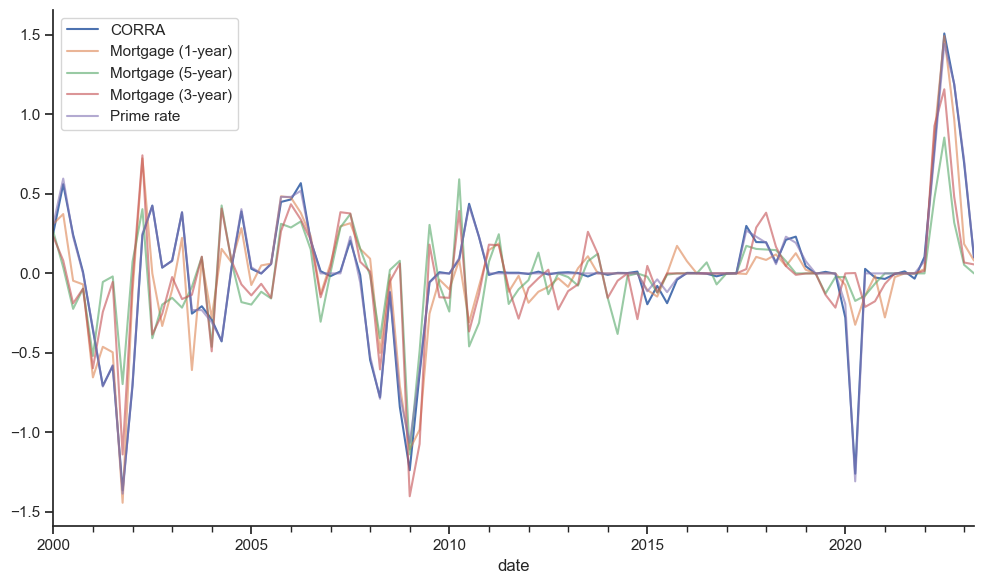

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
corra.plot(ax=ax)
prime.plot(ax=ax, alpha=0.6)
plt.legend(['CORRA', "Mortgage (1-year)", "Mortgage (5-year)", "Mortgage (3-year)", "Prime rate"])
plt.tight_layout()

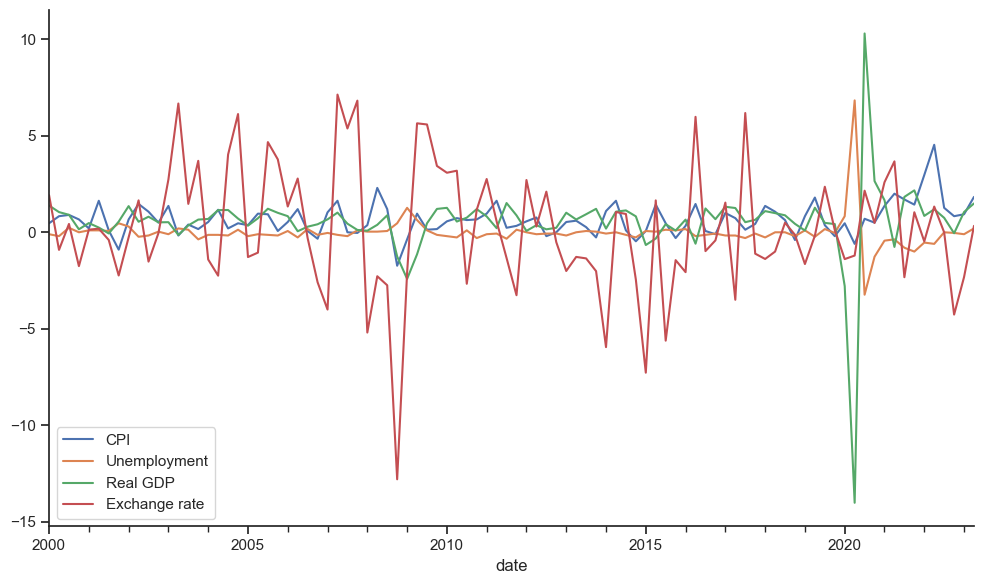

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

cpi.plot(ax=ax)
unemp.plot(ax=ax)
gdp.plot(ax=ax)
fx.plot(ax=ax)

ax.legend()

plt.legend(["CPI", "Unemployment", "Real GDP", "Exchange rate"])
plt.tight_layout()

In [12]:
## SUMMARY STATISTICS ##
np.round(
    pd.concat(
        [corra, prime, pred_sentiment_weighted_glove, cpi, unemp, gdp, fx], 
        axis=1).describe().loc[['mean', 'std', 'min', 'max']].T,
    3
).to_csv(os.path.join(directory, "Data", "output", "tables", "time_series_summary.csv"))

# Forecasting Models

In [13]:
def reg(X, y):
    ols = sm.OLS(y, X, missing='drop').fit(cov_type='HC1')
    # print(ols.summary())
    return ols

def gen_regressors(regressor_data):
    """
    regressor_data: input a list of dataframe/series', each variable
    should be its own dataset.
    """
    X = []
    for regressor in regressor_data:
        X.append(regressor)
    return sm.add_constant(pd.concat(X, axis=1))

## CORRA

All macro variables other than `sentiment` were lagged by 1 period (= 1 quarter). Sentiment was not lagged because the MPR is realsed at the *start* of every quarter, meaning that it is written in the last quarter. Therefore, we can assume that `sentiment` is implicitly lagged by a quarter already. 

In [14]:
y = corra['corra']

# SENTIMENT ONLY
regressor_list = [pred_sentiment_weighted_glove]
X = gen_regressors(regressor_list)
res1 = reg(X, y)

## ADDING lagged interest rate ##
regressor_list.append(corra['corra'].shift())
X = gen_regressors(regressor_list)
res2 = reg(X, y)

## ALL VARIABLES ##
regressor_list.extend([cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()])
X = gen_regressors(regressor_list)
res3 = reg(X, y)

## ALL VARIABLES, REMOVED lagged interest rate ##
regressor_list.pop(1)
X = gen_regressors(regressor_list)
res4 = reg(X, y)


## Summary Col ##
results = [res1, res2, res3]
model_names = ['(1)', '(2)', '(3)']
print(summary_col(results, model_names=model_names, stars=True))

# regressor_order = ["sentiment", "corra", "cpi", "ex_rate", "gdp", "unemp"]

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "corra_results.csv"))
)


                 (1)       (2)       (3)    
--------------------------------------------
R-squared      0.1146   0.4821    0.6377    
R-squared Adj. 0.1049   0.4706    0.6124    
const          -0.0122  -0.0093   -0.1864***
               (0.0438) (0.0329)  (0.0503)  
corra                   0.6152*** 0.6162*** 
                        (0.1233)  (0.0812)  
cpi                               0.1866*** 
                                  (0.0474)  
ex_rate                           0.0042    
                                  (0.0078)  
gdp                               0.1196**  
                                  (0.0521)  
sentiment      1.8697** 1.2943**  1.0923**  
               (0.8391) (0.5683)  (0.5256)  
unemp                             0.3848*** 
                                  (0.1209)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Sentiment explicity lagged

In [15]:
y = corra['corra']

# SENTIMENT ONLY
regressor_list = [pred_sentiment_weighted_glove.shift()] # Lagging sentiment 1-quarter
X = gen_regressors(regressor_list)
res1 = reg(X, y)

## ADDING lagged interest rate ##
regressor_list.append(corra['corra'].shift())
X = gen_regressors(regressor_list)
res2 = reg(X, y)

## ALL VARIABLES ##
regressor_list.extend([cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()])
X = gen_regressors(regressor_list)
res3 = reg(X, y)

## ALL VARIABLES, REMOVED lagged interest rate ##
regressor_list.pop(1)
X = gen_regressors(regressor_list)
res4 = reg(X, y)


## Summary Col ##
results = [res1, res2, res3]
model_names = ['(1)', '(2)', '(3)']
print(summary_col(results, model_names=model_names, stars=True))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "corra_results2.csv"))
)


                 (1)       (2)       (3)    
--------------------------------------------
R-squared      0.0581   0.4291    0.6044    
R-squared Adj. 0.0478   0.4164    0.5768    
const          -0.0118  -0.0033   -0.1955***
               (0.0435) (0.0334)  (0.0520)  
corra                   0.6462*** 0.6347*** 
                        (0.1185)  (0.0745)  
cpi                               0.1899*** 
                                  (0.0449)  
ex_rate                           0.0117    
                                  (0.0088)  
gdp                               0.1434*** 
                                  (0.0552)  
sentiment      1.3289** 0.1212    -0.0782   
               (0.6620) (0.4652)  (0.3946)  
unemp                             0.4288*** 
                                  (0.1267)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Prime rate

In [16]:
y = prime['prime']

# SENTIMENT ONLY
regressor_list = [pred_sentiment_weighted_glove]
X = gen_regressors(regressor_list)
res1 = reg(X, y)

## ADDING lagged interest rate ##
regressor_list.append(prime['prime'].shift())
X = gen_regressors(regressor_list)
res2 = reg(X, y)

## ALL VARIABLES ##
regressor_list.extend([cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()])
X = gen_regressors(regressor_list)
res3 = reg(X, y)

## ALL VARIABLES, REMOVED lagged interest rate ##
regressor_list.pop(1)
X = gen_regressors(regressor_list)
res4 = reg(X, y)

## Summary Col ##
results = [res1, res2, res3]
model_names = ['(1)', '(2)', '(3)']
print(summary_col(results, model_names=model_names, stars=True, ))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "prime_results.csv"))
)


                 (1)       (2)       (3)    
--------------------------------------------
R-squared      0.1125   0.4711    0.6192    
R-squared Adj. 0.1028   0.4593    0.5926    
const          -0.0063  -0.0075   -0.1798***
               (0.0429) (0.0326)  (0.0524)  
cpi                               0.1763*** 
                                  (0.0469)  
ex_rate                           0.0039    
                                  (0.0076)  
gdp                               0.1234**  
                                  (0.0541)  
prime                   0.6072*** 0.6176*** 
                        (0.1262)  (0.0847)  
sentiment      1.8154** 1.2614**  1.0473**  
               (0.8127) (0.5604)  (0.5124)  
unemp                             0.3860*** 
                                  (0.1262)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Mortgage rates

The 3-year mortgage for whatever reason, gives the best results (maybe look into this -- could say something about expectations and policy response lag?)

In [17]:
y = prime['mortgage_3']

# SENTIMENT ONLY
regressor_list = [pred_sentiment_weighted_glove]
X = gen_regressors(regressor_list)
res1 = reg(X, y)

## ADDING lagged interest rate ##
regressor_list.append(prime['mortgage_3'].shift())
X = gen_regressors(regressor_list)
res2 = reg(X, y)

## ALL VARIABLES ##
regressor_list.extend([cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()])
X = gen_regressors(regressor_list)
res3 = reg(X, y)

## ALL VARIABLES, REMOVED lagged interest rate ##
regressor_list.pop(1)
X = gen_regressors(regressor_list)
res4 = reg(X, y)

## Summary Col ##
results = [res1, res2, res3]
model_names = ['(1)', '(2)', '(3)']
print(summary_col(results, model_names=model_names, stars=True, ))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "mortgage3_results.csv"))
)


                 (1)      (2)       (3)    
-------------------------------------------
R-squared      0.1519   0.2258   0.4240    
R-squared Adj. 0.1427   0.2086   0.3839    
const          -0.0290  -0.0245  -0.1874***
               (0.0348) (0.0341) (0.0540)  
cpi                              0.1911*** 
                                 (0.0502)  
ex_rate                          0.0104    
                                 (0.0089)  
gdp                              0.0743    
                                 (0.0495)  
mortgage_3              0.2771*  0.1617    
                        (0.1482) (0.1176)  
sentiment      1.7736** 1.6268** 1.2886*** 
               (0.6914) (0.6704) (0.4912)  
unemp                            0.1885*   
                                 (0.1112)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


1-year mortgage has good results, might be more relevant than the 3-year mortgage since we are using the quarterly sentiment.

In [18]:
y = prime['mortgage_1']

# SENTIMENT ONLY
regressor_list = [pred_sentiment_weighted_glove]
X = gen_regressors(regressor_list)
res1 = reg(X, y)

## ADDING lagged interest rate ##
regressor_list.append(prime['mortgage_1'].shift())
X = gen_regressors(regressor_list)
res2 = reg(X, y)

## ALL VARIABLES ##
regressor_list.extend([cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()])
X = gen_regressors(regressor_list)
res3 = reg(X, y)

## ALL VARIABLES, REMOVED lagged interest rate ##
regressor_list.pop(1)
X = gen_regressors(regressor_list)
res4 = reg(X, y)

## Summary Col ##
results = [res1, res2, res3]
model_names = ['(1)', '(2)', '(3)']
print(summary_col(results, model_names=model_names, stars=True, ))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "mortgage1_results.csv"))
)


                 (1)       (2)       (3)    
--------------------------------------------
R-squared      0.1265   0.3831    0.5124    
R-squared Adj. 0.1170   0.3694    0.4784    
const          -0.0190  -0.0145   -0.1747***
               (0.0385) (0.0319)  (0.0481)  
cpi                               0.1650*** 
                                  (0.0577)  
ex_rate                           0.0061    
                                  (0.0078)  
gdp                               0.1084**  
                                  (0.0458)  
mortgage_1              0.5122*** 0.4233*** 
                        (0.1433)  (0.1155)  
sentiment      1.7589** 1.3883**  1.1044**  
               (0.7447) (0.5526)  (0.5392)  
unemp                             0.2714*** 
                                  (0.1046)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


5-year mortgages gives the worst results. This could be because of the time frame.

In [19]:
y = prime['mortgage_5']

# SENTIMENT ONLY
regressor_list = [pred_sentiment_weighted_glove]
X = gen_regressors(regressor_list)
res1 = reg(X, y)

## ADDING lagged interest rate ##
regressor_list.append(prime['mortgage_5'].shift())
X = gen_regressors(regressor_list)
res2 = reg(X, y)

## ALL VARIABLES ##
regressor_list.extend([cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()])
X = gen_regressors(regressor_list)
res3 = reg(X, y)

## ALL VARIABLES, REMOVED lagged interest rate ##
regressor_list.pop(1)
X = gen_regressors(regressor_list)
res4 = reg(X, y)

## Summary Col ##
results = [res1, res2, res3]
model_names = ['(1)', '(2)', '(3)']
print(summary_col(results, model_names=model_names, stars=True, ))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "mortgage5_results.csv"))
)


                 (1)      (2)       (3)    
-------------------------------------------
R-squared      0.1135   0.1271   0.3458    
R-squared Adj. 0.1039   0.1077   0.3002    
const          -0.0247  -0.0244  -0.1528***
               (0.0271) (0.0280) (0.0422)  
cpi                              0.1365*** 
                                 (0.0398)  
ex_rate                          0.0160**  
                                 (0.0081)  
gdp                              0.0769**  
                                 (0.0356)  
mortgage_5              0.1292   0.0525    
                        (0.1296) (0.1083)  
sentiment      1.1893** 1.1252** 0.7276*   
               (0.5320) (0.5459) (0.3930)  
unemp                            0.1897**  
                                 (0.0797)  
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Sentiment as Dependent

In [20]:
y = pred_sentiment_weighted_glove # sentiment as dependent

regressor_list = [cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()]
X = gen_regressors(regressor_list)
res1 = reg(X, y)

## Summary Col ##
results = [res1]
model_names = ['(1)']
print(summary_col(results, model_names=model_names, stars=True,))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "sentiment_results.csv"))
)


                 (1)   
-----------------------
const          -0.0094 
               (0.0127)
cpi            0.0038  
               (0.0097)
unemp          0.0390  
               (0.0274)
ex_rate        0.0066**
               (0.0027)
gdp            0.0220* 
               (0.0132)
R-squared      0.1389  
R-squared Adj. 0.0998  
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


## Exogenous sentiment?

In [21]:
estimated_sentiment = res1.predict(exog=X) # estimated sentiment with OLS

# Exog shock = predicted - acutal #
exog_senitment = pd.DataFrame(
    pred_sentiment_weighted_glove['sentiment'].iloc[1:] - estimated_sentiment, # ACTUAL - ESTIMATED
    columns=['Exogenous Sentiment']
)

exog_senitment.index = exog_senitment.index.astype('object') # Change to object type

# display(exog_senitment) # display

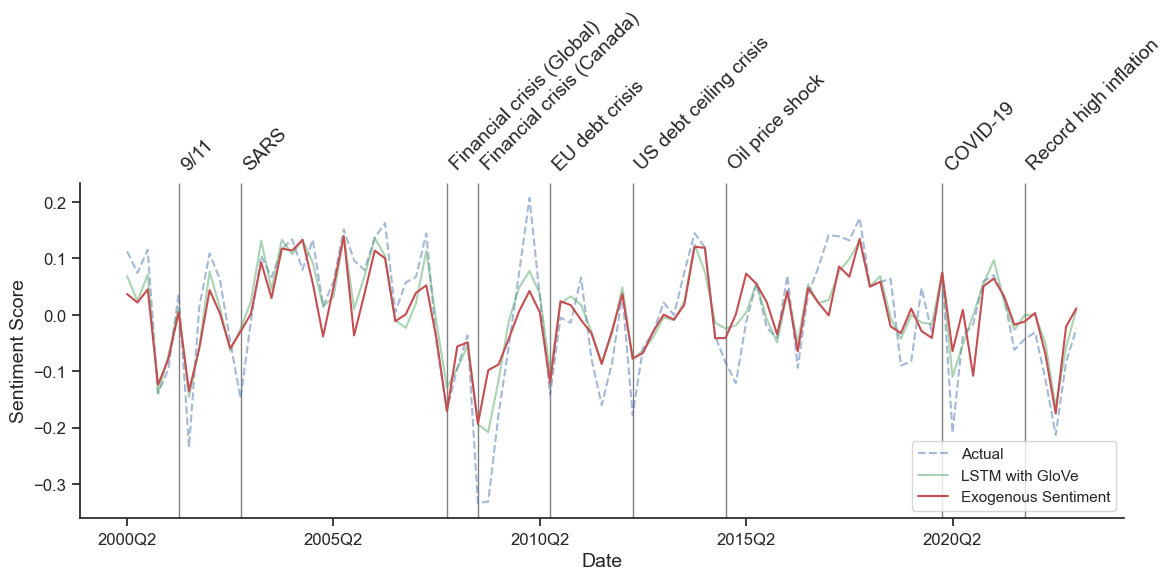

In [22]:
# Create a single dataframe that holds all three sentiment series for the figure...
sentiment_grouped = pd.concat(
    [
        exog_senitment.reset_index()['Exogenous Sentiment'], 
        actual_sentiment_by_mpr['sentiment'], 
        pred_sentiment_weighted_glove.reset_index()['sentiment'],
    ], 
    axis=1,
).dropna()

sentiment_grouped.index=exog_senitment.dropna().index
sentiment_grouped.columns=['exog_sent', 'actual', 'lstm']


# Plot prediction series'
fig, ax = plt.subplots(figsize=(12, 6))
sentiment_grouped['actual'].plot(ax=ax, label='Actual', alpha=0.5, linestyle='--')
sentiment_grouped['lstm'].plot(ax=ax, label="LSTM with GloVe", alpha=0.5, color='C2')
sentiment_grouped['exog_sent'].plot(ax=ax, label='Exogenous Sentiment', color='C3')

# Plot landmarks #
ax.axvspan(5, 5, color='grey', alpha=1) # 9/11
ax.axvspan(11, 11, color='grey', alpha=1) # SARS
ax.axvspan(31, 31, color='grey', alpha=1) # Fin crisis (Global)
ax.axvspan(34, 34, color='grey', alpha=1) # Fin crisis (CAN)
ax.axvspan(41, 41, color='grey', alpha=1) # EU debt crisis
ax.axvspan(49, 49, color='grey', alpha=1) # US debt ceiling crisis
ax.axvspan(58, 58, color='grey', alpha=1) # Oil price shock
ax.axvspan(79, 79, color='grey', alpha=1) # COVID
ax.axvspan(87, 87, color='grey', alpha=1) # Inflation spike


# Text labels for each landmark
font_size = 14
ax.text(5, 0.25, '9/11', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(11, 0.25, 'SARS', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(31, 0.25, 'Financial crisis (Global)', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(34, 0.25, 'Financial crisis (Canada)', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(41, 0.25, 'EU debt crisis', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(49, 0.25, 'US debt ceiling crisis', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(58, 0.25, 'Oil price shock', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(79, 0.25, 'COVID-19', rotation=45, verticalalignment='bottom', fontsize=font_size)
ax.text(87, 0.25, 'Record high inflation', rotation=45, verticalalignment='bottom', fontsize=font_size)


# Axis
ax.set_xlabel("Date", fontsize=font_size)
ax.set_ylabel("Sentiment Score", fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size-2)
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(directory, "Data", "OUTPUT", "figures", "exogenous_sentiment_series.png"), dpi=300)

## ALL Results WITHOUT sentiment as a regressor (all interest rates as dependent)

In [23]:
y0 = corra['corra']
y1 = prime['prime']
y2 = prime['mortgage_1']
y3 = prime['mortgage_3']
y4 = prime['mortgage_5']

regressor_list = [cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()]
X = gen_regressors(regressor_list)

# Results
res0 = reg(pd.concat([X, y0.shift()], axis=1), y0)
res1 = reg(pd.concat([X, y1.shift()], axis=1), y1)
res2 = reg(pd.concat([X, y2.shift()], axis=1), y2)
res3 = reg(pd.concat([X, y3.shift()], axis=1), y3)
res4 = reg(pd.concat([X, y4.shift()], axis=1), y4)

## Summary Col ##
results = [res0, res1, res2, res3, res4]
model_names = ['CORRA', 'Prime rate', 'Mortgage 1-year', 'Mortgage 3-year', 'Mortgage 5-year']
print(summary_col(results, model_names=model_names, stars=True,))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "results_no_sentiment.csv"))
)


                 CORRA    Prime rate Mortgage 1-year Mortgage 3-year Mortgage 5-year
------------------------------------------------------------------------------------
R-squared      0.6042     0.5871     0.4696          0.3554          0.3091         
R-squared Adj. 0.5815     0.5634     0.4391          0.3183          0.2694         
const          -0.1960*** -0.1892*** -0.1836***      -0.1979***      -0.1593***     
               (0.0525)   (0.0547)   (0.0483)        (0.0602)        (0.0448)       
corra          0.6318***                                                            
               (0.0729)                                                             
cpi            0.1894***  0.1790***  0.1668***       0.1934***       0.1388***      
               (0.0443)   (0.0437)   (0.0535)        (0.0502)        (0.0384)       
ex_rate        0.0111     0.0106     0.0132          0.0188*         0.0207**       
               (0.0083)   (0.0080)   (0.0082)        (0.0102)   

## ALL Results WITH sentiment as a regressor (all interest rates as dependent)

In [24]:
regressor_list = [pred_sentiment_weighted_glove, cpi.shift(), unemp.shift(), fx.shift(), gdp.shift()]
X = gen_regressors(regressor_list)

# Results
res0 = reg(pd.concat([X, y0.shift()], axis=1), y0)
res1 = reg(pd.concat([X, y1.shift()], axis=1), y1)
res2 = reg(pd.concat([X, y2.shift()], axis=1), y2)
res3 = reg(pd.concat([X, y3.shift()], axis=1), y3)
res4 = reg(pd.concat([X, y4.shift()], axis=1), y4)

## Summary Col ##
results = [res0, res1, res2, res3, res4]
model_names = ['CORRA', 'Prime rate', 'Mortgage 1-year', 'Mortgage 3-year', 'Mortgage 5-year']
print(summary_col(results, model_names=model_names, stars=True,))

# EXPORT TABLE
(
    summary_col(results, model_names=model_names, stars=True)
    .tables[0]
    .to_csv(os.path.join(directory, "data", "output", "tables", "results_w_sentiment.csv"))
)


                 CORRA    Prime rate Mortgage 1-year Mortgage 3-year Mortgage 5-year
------------------------------------------------------------------------------------
R-squared      0.6377     0.6192     0.5124          0.4240          0.3458         
R-squared Adj. 0.6124     0.5926     0.4784          0.3839          0.3002         
const          -0.1864*** -0.1798*** -0.1747***      -0.1874***      -0.1528***     
               (0.0503)   (0.0524)   (0.0481)        (0.0540)        (0.0422)       
corra          0.6162***                                                            
               (0.0812)                                                             
cpi            0.1866***  0.1763***  0.1650***       0.1911***       0.1365***      
               (0.0474)   (0.0469)   (0.0577)        (0.0502)        (0.0398)       
ex_rate        0.0042     0.0039     0.0061          0.0104          0.0160**       
               (0.0078)   (0.0076)   (0.0078)        (0.0089)   